In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import cftime
import datetime
import xarray as xr
import wget
import os
import glob
import matplotlib.pyplot as plt
import dask
import cartopy.crs as ccrs
%matplotlib inline

In [34]:
os.chdir('/Users/caramelo/Documents/0000_Unu_Engineering/wasabi_cloud_storage/gem/TMP')
grib_list_total=sorted(glob.glob('*0312_*.grib2'))
grib_list=grib_list_total[0:7]
grib_list

['CMC_reg_TMP_TGL_2_ps10km_2021030312_P000.grib2',
 'CMC_reg_TMP_TGL_2_ps10km_2021030312_P001.grib2',
 'CMC_reg_TMP_TGL_2_ps10km_2021030312_P002.grib2',
 'CMC_reg_TMP_TGL_2_ps10km_2021030312_P003.grib2',
 'CMC_reg_TMP_TGL_2_ps10km_2021030312_P004.grib2',
 'CMC_reg_TMP_TGL_2_ps10km_2021030312_P005.grib2',
 'CMC_reg_TMP_TGL_2_ps10km_2021030312_P006.grib2']

In [35]:
ds=xr.open_mfdataset(grib_list,concat_dim='valid_time',engine='cfgrib',combine='nested',parallel=True)

In [36]:
# Convert to celsius
ds=ds-273.15 #passage en celsius
t2m = ds.t2m 

# copy attributes to get nice figure labels and change Kelvin to Celsius
t2m.attrs = ds.t2m.attrs

t2m.attrs["units"] = "deg C"

In [50]:
ds

<xarray.Dataset>
Dimensions:            (valid_time: 7, x: 935, y: 824)
Coordinates:
    time               datetime64[ns] 2021-03-03T12:00:00
    step               (valid_time) timedelta64[ns] 00:00:00 ... 06:00:00
    heightAboveGround  int64 2
    latitude           (y, x) float64 dask.array<chunksize=(824, 935), meta=np.ndarray>
    longitude          (y, x) float64 dask.array<chunksize=(824, 935), meta=np.ndarray>
  * valid_time         (valid_time) datetime64[ns] 2021-03-03T12:00:00 ... 20...
Dimensions without coordinates: x, y
Data variables:
    t2m                (valid_time, y, x) float32 dask.array<chunksize=(1, 824, 935), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal 
    history:                 2021-03-04T16:44:27 GRIB to CDM+CF via cfgrib-0....

/Users/caramelo/Documents/python-virtual-environments/rdpsgrib/lib/python3.9/site-packages/xarray/plot/facetgrid.py:390: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


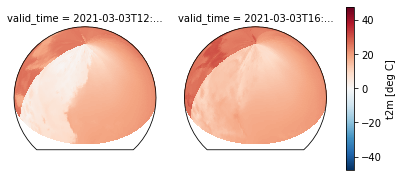

In [40]:
t2m=ds.t2m
p = t2m.isel(valid_time=[0, 4]).plot(
     transform=ccrs.PlateCarree(),
     col="valid_time",
     subplot_kws={"projection": ccrs.Orthographic(-80, 40)},
)

In [ ]:
#min_lon=-90
#min_lat=40
#max_lon=-55
#max_lat=75

#mask_lon= (ds.longitude >=min_lon) & (ds.longitude <=max_lon)
#mask_lat= (ds.latitude >=min_lat) & (ds.latitude <=max_lat)

#cropped_ds = ds.where(mask_lon & mask_lat, drop=True)
#cropped_ds

In [ ]:
fig,ax=plt.subplots(figsize=(15,15))

countries=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ds.t2m.isel(valid_time=1).plot(ax=ax)
countries.plot(ax=ax,facecolor='none',edgecolor='red')

Deux alternatives pour le traitement des fichiers: Soit convertir les coordonnées des stations en stereographique polaire ou bien transformer les cartes en projection lat lon et garder les coordonnées telles quelles lors de la requête.


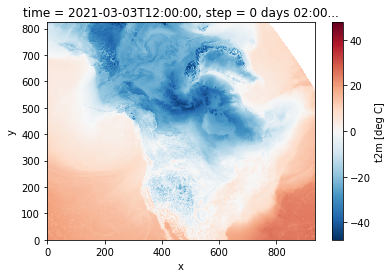

In [42]:
ds.t2m.isel(valid_time=[2]).plot()

# Première option: Changer les coordonnées des stations d'intérêt

Codes EPSG : https://spatialreference.org/ref/epsg/

Codes EPSG à prioriser pour le Québec: NAD83

In [3]:
coords_stations=pd.read_csv('Stations matrice scribe.csv')
coords_stations

,OACI,NOMSTN,LAT,LON
0,CYUL,MONTREAL (DORVAL),45.4667,-73.7500
1,CYOW,OTTAWA,45.3167,-75.6667
2,CYVO,VAL D'OR,48.0500,-77.7833
3,CYSC,SHERBROOKE,45.4333,-71.6833
4,CYQB,QUEBEC,46.8000,-71.4000
5,CYRJ,ROBERVAL,48.5167,-72.2667
6,CYGL,LA GRANDE RIVIERE,53.6333,-77.7000
7,CYBC,BAIE COMEAU,49.1333,-68.2000
8,CYZV,SEPT-ILES,50.2167,-66.2500
9,CYRQ,TROIS-RIVIÈRES (A),46.3539,-72.6792


In [46]:
from pyproj import Proj, transform

inProj = Proj(init='epsg:3857')
outProj = Proj(init='epsg:4326')
x1,y1 = -11705274.6374,4826473.6922
x2,y2 = transform(inProj,outProj,x1,y1)
print(x2,y2)

-105.15027111593008 39.72785727727918


/Users/caramelo/Documents/python-virtual-environments/rdpsgrib/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/caramelo/Documents/python-virtual-environments/rdpsgrib/lib/python3.9/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/caramelo/Documents/python-virtual-environments/rdpsgrib/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarn

# Deuxième option: Changer la projection des cartes de base